# Summarize CHM results from DINOv3 - read and plot

In [12]:
library(dplyr)
library(ggplot2)
library(tidyr)
library(data.table)
library(patchwork)

In [3]:
# Read data (use data.table for speed with large CSVs)
area_stats <- fread('/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5/chm_002m_height_class_areas_by_file.csv')
dim(area_stats)

[1] 1288   19

In [4]:
head(area_stats)

file,area_0-0.25m,n_pixels_0-0.25m,area_0.25-1m,n_pixels_0.25-1m,area_1-2m,n_pixels_1-2m,area_2-3m,n_pixels_2-3m,area_3-5m,n_pixels_3-5m,area_5-10m,n_pixels_5-10m,area_10-20m,n_pixels_10-20m,area_20-50m,n_pixels_20-50m,total_valid_area_km2,n_valid_pixels
<chr>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>
/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5/002m/WV02_20100702_M1BS_1030010005333400-sr-02m.chm.tif,1934.8403,483710067,0,0,98.26921,24567302,30.12323,7530807,23.24594,5811486,6.156716,1539179,1.408252,352063,0.382964,95741,2094.4277,523606931
/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5/002m/WV02_20100707_M1BS_1030010005554F00-sr-02m.chm.tif,350.2648,87566201,0,0,192.26044,48065109,119.22684,29806711,174.97635,43744087,224.445040,56111260,196.055044,49013761,288.828296,72207074,2162.4106,540602643
/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5/002m/WV02_20100709_M1BS_1030010006214C00-sr-02m.chm.tif,409.4216,102355391,0,0,20.07471,5018677,11.05750,2764374,18.71089,4677722,8.490392,2122598,0.780268,195067,0.063088,15772,468.5994,117149849
/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5/002m/WV02_20100709_M1BS_1030010006544A00-sr-02m.chm.tif,159.0235,39755880,0,0,38.14316,9535791,24.12595,6031488,53.67378,13418444,157.128828,39282207,449.959528,112489882,782.168552,195542138,2185.2116,546302896
/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5/002m/WV02_20100709_M1BS_1030010006AC3100-sr-02m.chm.tif,132.1410,33035240,0,0,30.86909,7717272,18.63660,4659150,29.82039,7455097,39.699904,9924976,51.938984,12984746,37.002384,9250596,342.7358,85683954
/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5/002m/WV02_20100710_M1BS_103001000640E200-sr-02m.chm.tif,1002.8535,250713376,0,0,90.95397,22738493,48.39494,12098736,74.59332,18648329,34.983612,8745903,5.126468,1281617,1.169700,292425,1258.2552,314563812


In [7]:
# Calculate total valid area
total_area_km2 <- sum(area_stats$total_valid_area_km2)
n_files <- nrow(area_stats)

cat(sprintf("Total valid area: %s km²\n", format(round(total_area_km2), big.mark = ",")))
cat(sprintf("Number of files: %d\n", n_files))

# Use in plot subtitle
subtitle <- sprintf("Based on %d tiles covering %s km² (July-August)",
                    n_files,
                    format(round(total_area_km2), big.mark = ","))

# Reshape to long format
area_long <- area_stats %>%
  select(file, starts_with('area_')) %>%
  pivot_longer(
    cols = starts_with('area_'),
    names_to = "height_class",
    values_to = "area_km2",
    names_prefix = "area_"
  ) %>%
  filter(height_class != 'total_valid_area_km2')

# Extract numeric values
area_long <- area_long %>%
  mutate(
    height_lower = as.numeric(gsub("([0-9.]+)-.*", "\\1", height_class))
  )

# Combine 10-20m and 20-50m into ">10m"
area_long <- area_long %>%
  mutate(
    height_class_combined = case_when(
      height_lower >= 10 ~ ">10m",
      TRUE ~ height_class
    ),
    # Update height_lower for combined class
    height_lower_combined = ifelse(height_lower >= 10, 10, height_lower)
  )

# Aggregate combined classes
area_long_combined <- area_long %>%
  group_by(file, height_class_combined, height_lower_combined) %>%
  summarise(area_km2 = sum(area_km2), .groups = 'drop')

# Create ordered factor
area_long_combined <- area_long_combined %>%
  mutate(
    height_class_combined = factor(height_class_combined, 
                                   levels = unique(height_class_combined[order(height_lower_combined)]))
  )

Total valid area: 1,795,803 km²
Number of files: 1288


In [9]:
# Bootstrap and summarize

# STEP 1: Define bootstrap_ci function FIRST
bootstrap_ci <- function(x, n_boot = 1000, conf = 0.95) {
  boot_totals <- replicate(n_boot, {
    sample_idx <- sample(length(x), replace = TRUE)
    sum(x[sample_idx])
  })
  
  total <- sum(x)
  ci_lower <- quantile(boot_totals, (1 - conf) / 2)
  ci_upper <- quantile(boot_totals, 1 - (1 - conf) / 2)
  
  return(data.frame(
    total = total,
    ci_lower = ci_lower,
    ci_upper = ci_upper
  ))
}

area_summary <- area_long_combined %>%
  group_by(height_class_combined, height_lower_combined) %>%
  summarise(
    bootstrap_ci(area_km2, n_boot = 1000, conf = 0.95),
    .groups = 'drop'
  ) %>%
  mutate(
    ci_half_width = (ci_upper - ci_lower) / 2,
    total_formatted = format(round(total), big.mark = ","),
    ci_formatted = paste0("±", format(round(ci_half_width), big.mark = ",")),
    height_for_color = pmin(height_lower_combined, 5)
  )

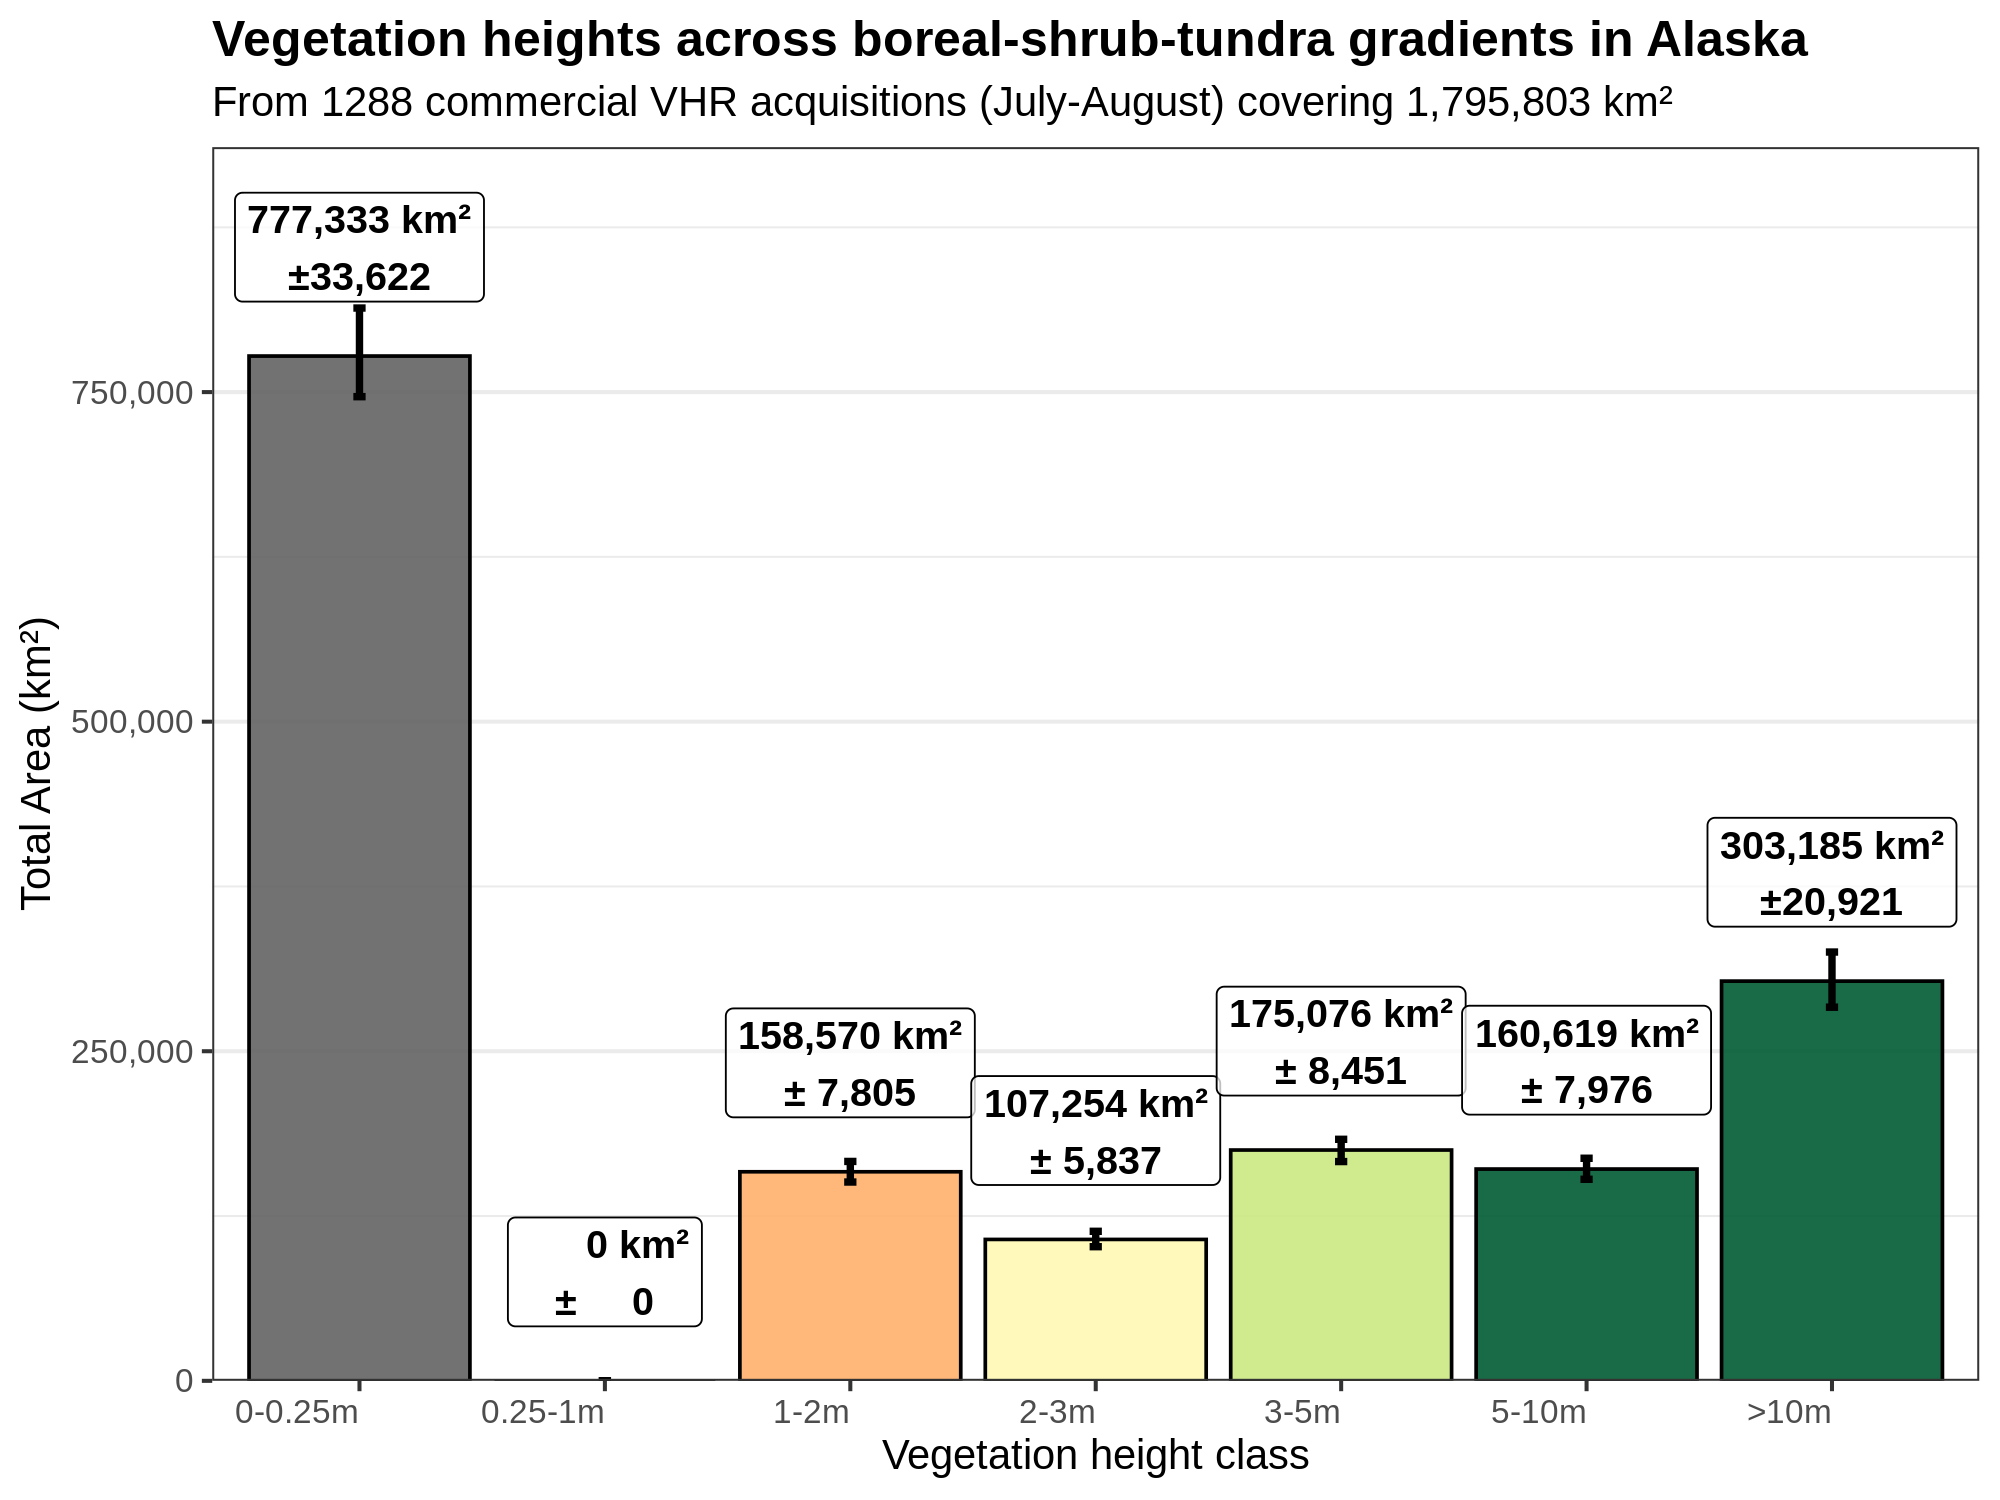

In [16]:
# Calculate totals
total_area_km2 <- sum(area_stats$total_valid_area_km2)
n_files <- nrow(area_stats)

# Forest height colors
forest_ht_colors <- c('#636363','#fc8d59','#fee08b','#ffffbf',
                      '#d9ef8b','#91cf60','#1a9850','#005a32')

# Plot with forest height colormap
p <- ggplot(area_summary, aes(x = height_class_combined, y = total, fill = height_for_color)) +
  geom_col(alpha = 0.9, color = "black") +
  scale_fill_gradientn(
    colors = forest_ht_colors,
    limits = c(0, 5),
    oob = scales::squish,
    guide = "none"
  ) +
  geom_errorbar(aes(ymin = ci_lower, ymax = ci_upper), 
                width = 0.05, linewidth = 1) +
  geom_label(aes(label = paste0(total_formatted, " km²\n", ci_formatted)),
            vjust = -0.5, size = 4, fontface = "bold", color = "black", fill="white", alpha=0.75) +
  labs(
    title = "Vegetation heights across boreal-shrub-tundra gradients in Alaska",
    subtitle = sprintf("From %d commercial VHR acquisitions (July-August) covering %s km²",
                       n_files, format(round(total_area_km2), big.mark = ",")),
    x = "Vegetation height class",
    y = "Total Area (km²)"
  ) +
  scale_y_continuous(labels = scales::comma, expand = expansion(mult = c(0, 0.15))) +
  theme_bw(base_size = 12) +
  theme(
    axis.text.x = element_text(angle = 0, hjust = 1),
    plot.title = element_text(face = "bold"),
    panel.grid.major.x = element_blank()
  )

options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 250, warn=-1)
print(p)

# Export summary table
write.csv(area_summary, "height_class_area_summary.csv", row.names = FALSE)

# # Print key result
# cat("\n=== KEY RESULT ===\n")
# result_0.25_5m <- area_summary %>% filter(height_class_combined == "0.25-5m")
# cat(sprintf("Area with vegetation 0.25-5m: %s km² (95%% CI: %s)\n",
#             result_0.25_5m$total_formatted,
#             result_0.25_5m$ci_formatted))

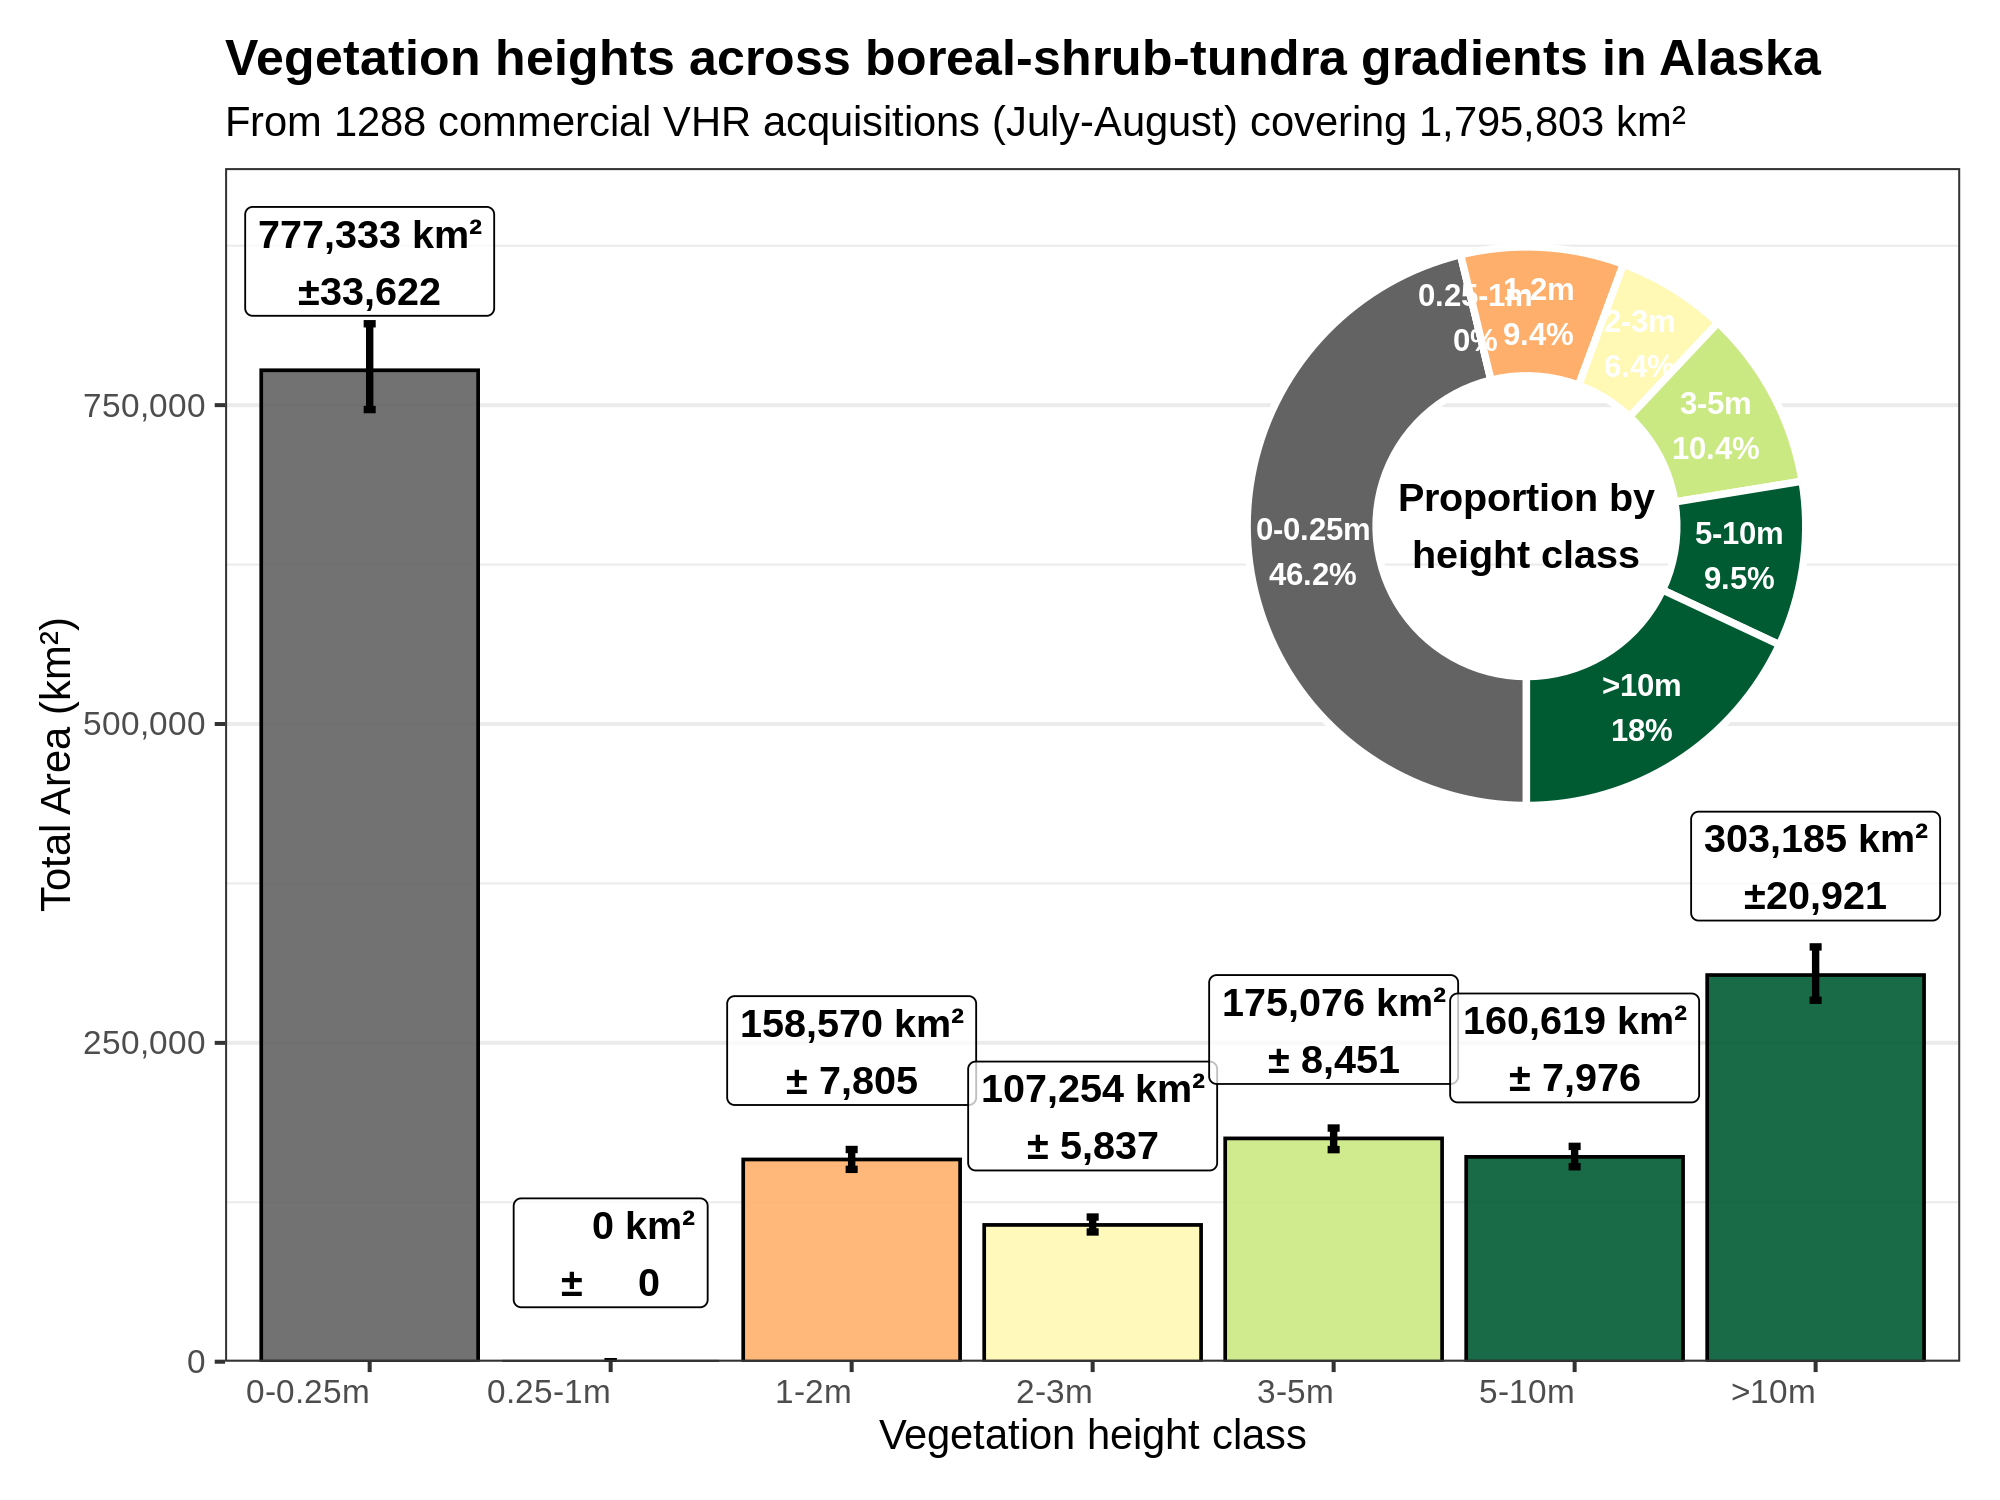

In [17]:
# Calculate proportions
area_summary <- area_summary %>%
  mutate(
    proportion = total / sum(total),
    pct = round(proportion * 100, 1),
    pct_label = paste0(height_class_combined, "\n", pct, "%")
  )

# Create donut plot with centered title
p_donut <- ggplot(area_summary, aes(x = 2, y = total, fill = height_for_color)) +
  geom_col(color = "white", linewidth = 1, position = "stack") +
  geom_text(aes(label = pct_label), 
            position = position_stack(vjust = 0.5),
            color = "white", fontface = "bold", size = 3.15) +
  annotate("text", x = 0.5, y = 0.5, 
           label = "Proportion by\nheight class", 
           size = 4, fontface = "bold", hjust = 0.5, vjust = 0.5) +  # Center text
  coord_polar(theta = "y", start = pi) +
  xlim(c(0.5, 2.5)) +
  scale_fill_gradientn(
    colors = forest_ht_colors,
    limits = c(0, 5),
    oob = scales::squish,
    guide = "none"
  ) +
  theme_void()

# Combine with bar plot
combined <- p + 
  inset_element(p_donut, 
                left = 0.3, bottom = 0.4,
                right = 1.2, top = 1.0)

print(combined)


In [18]:
# Save plot
ggsave("/explore/nobackup/projects/above/misc/ABoVE_Shrubs/paper_figs/alaska_chm_results_height_class_areas_with_ci.png", combined, width = 8, height = 6, dpi = 300)